# Import thư viện

In [1]:
import cv2
from skimage.feature import hog
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import GRU, Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Đọc và xử lý dữ liệu số

In [2]:
def read_data_number(data_path, time_col="thoi_gian"):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(data_path)
    
    # Chuyển đổi cột thời gian sang kiểu datetime và đặt làm index
    data[time_col] = pd.to_datetime(data[time_col])
    data.set_index(time_col, inplace=True)
    
    # Tái lấy mẫu và tính toán thống kê
    y_t = data[['Mực nước hồ (m)', 'Lưu lượng đến hồ (m³/s)']].resample("D").mean()
    
    return y_t

In [3]:
def create_dataframe(y_t, time_col="thoi_gian", value_col_1="y_t_1", value_col_2="y_t_2"):
    df = pd.DataFrame({time_col: y_t.index, 
                       value_col_1: y_t['Mực nước hồ (m)'].values, 
                       value_col_2: y_t['Lưu lượng đến hồ (m³/s)'].values})
    return df

# Áp dụng LSTM để dự đoán

### Tiền xử lý dữ liệu

In [4]:
def create_dataset(X, y, n_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i+n_steps])
        ys.append(y[i+n_steps])
    return np.array(Xs), np.array(ys)

In [5]:
# Chuẩn hóa dữ liệu
def scaler(df, time_steps):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X = df[['y_t_1', 'y_t_2']]
    y = df[['y_t_1']]

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

    # Tạo nhãn cho dữ liệu
    X_data, y_data = create_dataset(X, y, time_steps)

    return scaler_X, scaler_y, X_data, y_data

In [6]:
# Khôi phục dữ liệu sau chuẩn hóa
def inverse_transform_data(scaler, y_pred, y_test):
    y_pred_predict = scaler.inverse_transform(y_pred)
    y_pred_predict = pd.DataFrame(y_pred_predict)

    y_test = scaler.inverse_transform(y_test)
    y_test = pd.DataFrame(y_test)

    return y_pred_predict, y_test

### Chia dữ liệu

In [7]:
# Chuẩn hóa dữ liệu
def split_data(X_data, y_data, time_steps):
    # Chia dữ liệu thành tập huấn luyện, kiểm tra và test
    train_length = int(len(X_data) * 0.7)
    val_length = int((len(X_data) - train_length) / 2)

    X_train, y_train = X_data[:train_length], y_data[:train_length]
    X_val, y_val = X_data[train_length:train_length+val_length], y_data[train_length:train_length+val_length]
    X_test, y_test = X_data[-val_length:], y_data[-val_length:]

    # Reshape dữ liệu đầu vào
    X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[2])
    X_val = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[2])
    X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[2])

    print("Kích thước X_train:", X_train.shape)
    print("Kích thước X_val:", X_val.shape)
    print("Kích thước X_test:", X_test.shape)
    print("Kích thước y_train:", y_train.shape)
    print("Kích thước y_val:", y_val.shape)
    print("Kích thước y_test:", y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

### Xây dựng mô hình LSTM

In [8]:
def train_model(X_train, y_train, X_val, y_val, epochs, batch_size, save_best_model):
    # Xác định kích thước đầu vào
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    # Xây dựng mô hình GRU
    x = GRU(32, activation='tanh', return_sequences=False)(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Fully Connected Layer
    output_layer = Dense(1, activation='sigmoid')(x)
    
    # Khởi tạo model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile mô hình
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')
    
    # Callback lưu model tốt nhất
    model_checkpoint = ModelCheckpoint(save_best_model, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    
    # Train mô hình
    history = model.fit(X_train, y_train, 
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[model_checkpoint])
    
    return model, history

### Đánh giá mô hình

In [9]:
# Xác định điểm bất thường
def evaluate_outside_confidence(y_test, y_true, alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_test
    mean_yt = np.mean(y_test)
    std_yt = np.std(y_test, ddof=1)  # ddof=1 để tính std của mẫu

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_test)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_test)))

    # Xác định các index mà y_test nằm ngoài khoảng tin cậy
    outside_ci_indices = np.where((y_test < ci_lower) | (y_test > ci_upper))[0]

    # Truy xuất dữ liệu đúng cách
    y_t_outside = y_test.iloc[outside_ci_indices]
    y_true_outside = y_true.iloc[outside_ci_indices]

    return y_t_outside, y_true_outside

In [10]:
def evaluate_metrics(y_true, y_pred):
    # Chuyển về numpy array 1D để mọi phép tính sum đều cho ra scalar
    y_true_arr = np.ravel(y_true)
    y_pred_arr = np.ravel(y_pred)

    mae = round(mean_absolute_error(y_true_arr, y_pred_arr), 6)
    mse = round(mean_squared_error(y_true_arr, y_pred_arr), 6)
    rmse = round(np.sqrt(mse), 6)
    
    # Tính sai số dự báo
    errors = y_true_arr - y_pred_arr
    
    # Tracking Signal: TS = Tổng sai số dự báo tích lũy / Tổng độ lệch tuyệt đối của sai số
    tracking_signal = np.sum(errors) / np.sum(np.abs(errors))
    tracking_signal = round(tracking_signal, 6)
    
    # NSE (Nash–Sutcliffe Efficiency):
    # NSE = 1 - [ sum((y_true - y_pred)^2) / sum((y_true - mean(y_true))^2 ) ]
    numerator   = np.sum((y_true_arr - y_pred_arr) ** 2)
    denominator = np.sum((y_true_arr - np.mean(y_true_arr)) ** 2)
    
    # Sau khi ravel, denominator là float; chỉ cần so sánh bình thường
    if denominator == 0:
        nse = np.nan
    else:
        nse = 1 - numerator / denominator
        nse = round(nse, 6)
    
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Tracking Signal": tracking_signal,
        "NSE": nse
    }

### Dự báo và trực quan

In [11]:
# Trực quan hóa dữ liệu dự báo không dùng index
def plot_forecast(y_true, y_pred, title="Lake level forecast", alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_true
    mean_yt = np.mean(y_true)
    std_yt = np.std(y_true, ddof=1)

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_true)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_true)))

    # Tạo trục x là các chỉ mục tuần tự
    x = np.arange(len(y_true))

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))

    # Vẽ dữ liệu thực tế
    plt.plot(x, y_true, label="Actual value", color="blue", linestyle='-', alpha=0.7)

    # Vẽ dự báo
    plt.plot(x, y_pred, label="Predicted value", color="red", linestyle='--', alpha=0.7)

    # Vẽ vùng khoảng tin cậy 99.9%
    plt.fill_between(x, ci_lower, ci_upper, color='gray', alpha=0.3, label='99.9% CI')

    # Thiết lập tiêu đề và nhãn
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Water Level (m)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # Hiển thị biểu đồ
    plt.show()

# Thực hiện từng phần

### Tiền xử lý dữ liệu số

In [12]:
# Đọc dữ liệu đầu vào
path_data = r"E:\AIRC_NCS_Research\CoChau\DTAA_2025_Fusion_Data\DataSetKaNak\KaNak.csv"
data = read_data_number(path_data, time_col="thoi_gian")

# Tạo DataFrame chứa thời gian và mực nước
y_t = create_dataframe(data, time_col="thoi_gian", value_col_1="y_t_1", value_col_2="y_t_2")

### Chia dữ liệu

In [13]:
time_steps = 7

scaler_X, scaler_y, X_data, y_data = scaler(y_t, time_steps)
# X_data, y_data = scaler_v1(df_ts, time_steps)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_data, y_data, time_steps)

Kích thước X_train: (1017, 7, 2)
Kích thước X_val: (218, 7, 2)
Kích thước X_test: (218, 7, 2)
Kích thước y_train: (1017, 1)
Kích thước y_val: (218, 1)
Kích thước y_test: (218, 1)


### Huấn luyện ARIMA

In [14]:
model, history = train_model(X_train, y_train,
                             X_val, y_val,
                             epochs=200,
                             batch_size=16,
                             save_best_model='./BestModel/best_model_goc_GRU_KN.hdf5')


Epoch 1/200

61/64 [===========================>..] - ETA: 0s - loss: 0.0540
Epoch 1: val_loss improved from inf to 0.12702, saving model to ./BestModel\best_model_goc_GRU_KN.hdf5
64/64 [==============================] - 2s 8ms/step - loss: 0.0528 - val_loss: 0.1270
Epoch 2/200
63/64 [============================>.] - ETA: 0s - loss: 0.0142
Epoch 2: val_loss did not improve from 0.12702


c:\Users\ductr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 0s 3ms/step - loss: 0.0142 - val_loss: 0.1573
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.0145
Epoch 3: val_loss did not improve from 0.12702
64/64 [==============================] - 0s 3ms/step - loss: 0.0142 - val_loss: 0.1645
Epoch 4/200
57/64 [=========================>....] - ETA: 0s - loss: 0.0122
Epoch 4: val_loss did not improve from 0.12702
64/64 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.2092
Epoch 5/200
63/64 [============================>.] - ETA: 0s - loss: 0.0101
Epoch 5: val_loss did not improve from 0.12702
64/64 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.1408
Epoch 6/200
62/64 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 6: val_loss improved from 0.12702 to 0.11300, saving model to ./BestModel\best_model_goc_GRU_KN.hdf5
64/64 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.1130
Epoch 7/200
6

### Đánh giá mô hình dự báo trên tập test

In [15]:
# Đọc model tốt nhất
from keras.models import load_model
model = load_model('./BestModel/best_model_goc_GRU_KN.hdf5')

# Dự đoán trên tập validation
y_pred = model.predict(X_test)

y_pred, y_test = inverse_transform_data(scaler_y, y_pred, y_test)

evaluate_metrics(y_test, y_pred)

7/7 [==============================] - 0s 2ms/step


{'MAE': 0.629753,
 'MSE': 0.582276,
 'RMSE': 0.76307,
 'Tracking Signal': 0.010261,
 'NSE': 0.975674}

c:\Users\ductr\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


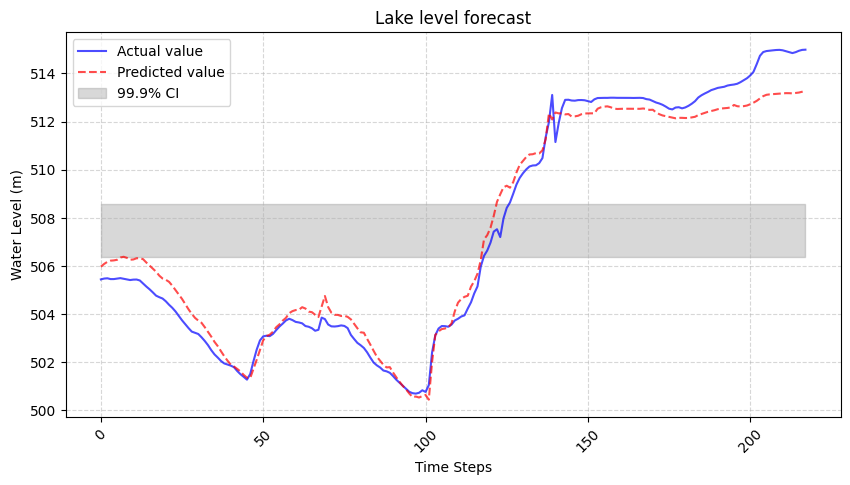

In [16]:
plot_forecast(y_test, y_pred)

In [17]:
y_t_out, y_true_out = evaluate_outside_confidence(y_test, y_pred)

# Đánh giá
evaluate_metrics(y_true_out, y_t_out)

{'MAE': 0.616967,
 'MSE': 0.563228,
 'RMSE': 0.750485,
 'Tracking Signal': -0.07048,
 'NSE': 0.971871}